In [1]:
import time
import requests
import pandas as pd
import numpy as np
import os
from importlib.machinery import SourceFileLoader
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# The Mobius python wrapper is not installed as a python library, so we import the source files manually
mobius_path = '../../' # Relative path from this notebook to Mobius/
wr = SourceFileLoader('mobius', mobius_path + 'PythonWrapper/mobius.py').load_module()
cu = SourceFileLoader('mobius_calib_uncert_lmfit', mobius_path + 'PythonWrapper/mobius_calib_uncert_lmfit.py').load_module()

# Load the program that can run the PERSiST model
shared_ext = 'dll'
if os.name == 'posix' : shared_ext = 'so'
wr.initialize(mobius_path + 'Applications/Persist/persist.' + shared_ext)

In [2]:
# This function is copied from MobiusSetups/HydroBasinsAutomation/mobiushyba.py

def openmeteo_sampler(lon, lat, start_dt, end_dt) :
	
	# What data we want to request from the server
    vars = "temperature_2m,precipitation"

    # The location of the server and data about the request
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude="+str(lat)+"&longitude="+str(lon)+"&start_date="+start_dt+"&end_date="+end_dt+"&hourly="+vars+"&timezone=auto"

    # This 'while' loop repeats forever until we manually exit it.
    while True :

        # This sends the request and tries to parse the result
        response = requests.get(url)
        res = response.json()

        # If there was no error, we have what we wanted, so we can exit from this 'while' loop using a 'break'
        if 'error' not in res or not res['error'] :
            break
        
        # If there was an error that mentions that we should wait for a minute or hour, do that and try again.
        if 'Please try again in one minute' in res['reason'] :
            
            print('Delaying openmeteo request one minute due to minutely request limit exceeded.')
            time.sleep(70) # Wait for a little over a minute just in case
            continue # Restarts at the top of the 'while' loop
            
        elif 'Please try again in the next hour' in res['reason'] :
            print('Delaying openmeteo request one hour due to hourly request limit exceeded.')
            time.sleep(3660) # Wait for 61 minutes
            continue # Restarts at the top of the 'while' loop
            
        else :
            # Worst case, we got an error we don't know how to handle, so we have to stop the execution of the program and
            # report the error
            raise ValueError('OpenMeteo request returned error:\n' + res['reason'])


    # When the request was successful, format the downloaded data into a pandas.DataFrame
    df = pd.DataFrame.from_records(res['hourly'])
    
    # Format the 'time' column into a time datatype and set it as the index of the data
    df['time']= pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    
    # The data was on hourly format, we want to "resample" it to one value per day.
    df = df.resample('D').agg({
        'temperature_2m':'mean',
        'precipitation':'sum',
    })
    
    # Rename the variables to what they are called in the PERSiST model
    df.rename(columns={
        'temperature_2m' : 'Air temperature',
        'precipitation' : 'Actual precipitation',
    }, inplace=True)
	
    return df

,Air temperature,Actual precipitation
time,,
2020-01-01,-1.491667,0.0
2020-01-02,-0.558333,0.1
2020-01-03,-0.562500,1.4
2020-01-04,-4.000000,0.0
2020-01-05,-5.254167,1.7


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

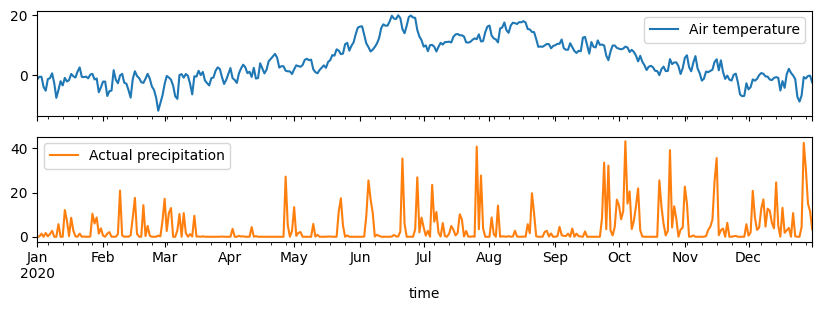

In [3]:
# Downloading the meteorological data should only be necessary to do once if you successfully store it in an input file (below)

# Get the meteorological data.
# It is important that you set the date range the same here and in template_inputs.dat
met_df = openmeteo_sampler(9.727, 60.373, '2020-01-01', '2020-12-31')

# See if it looks sensible on tabular form
display(met_df.head())

# See if the plot of the series look sensible
met_df.plot(subplots=True, figsize=(10, 3))

../../PythonWrapper/mobius_calib_uncert_lmfit.py:239: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return pd.date_range(start=start_date, periods=timesteps, freq='%d%s%s' % (magnitude, type, 'S' if type=='M' else ''))


<Axes: xlabel='Date'>

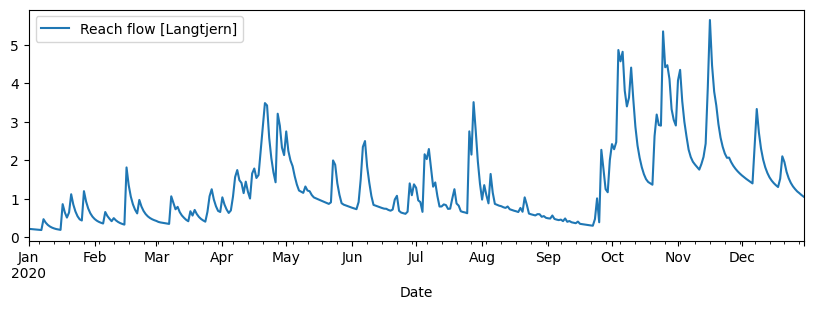

In [4]:
# Initialize a setup of the PERSiST model
ds = wr.DataSet.setup_from_parameter_and_input_files('params.dat', 'template_inputs.dat')

# Write the 
for name in met_df.columns :
    ds.set_input_series(name, [], met_df[name].values)

# Test-run the model. This will not have calibrated results yet, but you can see if the order of magnitude is reasonable at least.
ds.run_model()

# Extract some results
# The second argument is a list of pairs. Each pair is (name, indexes), where name is the name of a result series (same as displayed
# in MobiView, and indexes is a list of indexes giving the specific instance of that result series.
res_df = cu.get_result_dataframe(ds, [('Reach flow', ['Langtjern'])])

# Plot the results
res_df.plot(figsize=(10, 3))

In [5]:
# Save the input file so that next time you can just reload it without running the openmeteo request

ds.write_inputs_to_file('inputs.dat')

In [6]:
# Next time you work with this dataset, you can just load it like this:

# ds = wr.DataSet.setup_from_parameter_and_input_files('params.dat', 'inputs.dat')
# ds.run_model() # Usually a good idea to run it once first so that everything is initialized

In [15]:
# Do some "sensitivity analysis" (just a toy example)
# There are better ways to do this, including what is in PythonWrapper/simple_monte_carlo.py

# Bad sampler, should be more randomized... but good enough for illustration
def sample(mn, mx, n) :
    result = np.arange(mn, mx, (mx-mn)/n)
    np.random.shuffle(result)
    return result

n_samples = 100
n_ts      = ds.get_next_timesteps()

# Sample a range of parameter values for some parameters.
ddfetp = sample(0.05, 0.35, n_samples)
tc     = sample(1, 5, n_samples)

# Allocate space to store the results of the model runs
A = np.zeros((n_samples, n_ts))

# This function runs the model once with parameter sample nr. i and stores the results
def run_instance(i) :
    # Make a copy of the dataset to work with so that they don't overwrite one another if we run many instances in parallel
    ds2 = ds.copy(copyresults=False, borrowinputs=True)

    # Write the parameter values for the current instance into the dataset copy
    ds2.set_parameter_double("Degree day evapotranspiration", ["All"], ddfetp[i])
    ds2.set_parameter_double("Time constant", ["Soilwater", "All"], tc[i])

    # Run the dataset copy with these values
    ds2.run_model()

    # Store the model results with this parameter set. In this case we look at the river discharge
    A[i, :] = ds2.get_result_series("Reach flow", ["Langtjern"])

    # Get rid of the memory allocated for ds2 to not use up all the memory on your PC.
    ds2.delete()
    return 0

run_in_parallel = True

# It is in general better to run in parallel, but the below shows both options to illustrate better what it is actually doing

if run_in_parallel :
    
    Parallel(n_jobs=-1, verbose=1, backend="threading")(map(delayed(run_instance), range(n_samples)))
    
else :
    
    for i in range(n_samples) :
        run_instance(i)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


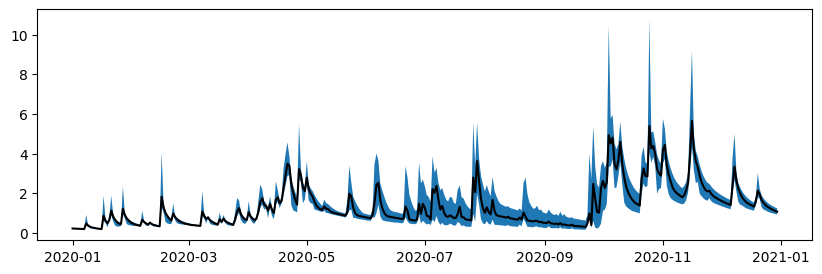

In [17]:
# Do something interesting with the result values you have stored

# Extract quantiles of the model result values at each time step
q = [0.05, 0.5, 0.95]
quant = np.quantile(A, q, axis=0)
dates = cu.get_date_index(ds)


fig, ax = plt.subplots(1, figsize=(10, 3))

# Fill a background color between the 5% and 95% percentiles
ax.fill_between(dates, quant[0, :], quant[2, :])

# Plot a solid line for the median
ax.plot(dates, quant[1, :], color='k')


In [ ]:
# You could also use similar techniques to run different scenarios etc.